In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
from sklearn.metrics import roc_curve, roc_auc_score
from scipy import interpolate
from sklearn.utils import shuffle

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
from tensorflow.python.client import device_lib
physical_gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_gpus[0], True)

2024-08-06 14:30:39.967050: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2024-08-06 14:30:40.016370: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: NVIDIA GeForce GTX 1080 Ti major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:5e:00.0
2024-08-06 14:30:40.016866: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2024-08-06 14:30:40.019254: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2024-08-06 14:30:40.021104: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2024-08-06 14:30:40.021486: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10.0
2024-08-06 14:30:40.023589: I tensorflow/stream_executor

In [3]:
#Reading files into a log
import sys
import logging

nblog = open("nb_id.log", "a+")
sys.stdout.echo = nblog
sys.stderr.echo = nblog

get_ipython().log.handlers[0].stream = nblog
get_ipython().log.setLevel(logging.INFO)

%autosave 5

Autosaving every 5 seconds


In [3]:
np.random.seed(42)

In [4]:
tf.random.set_seed(8)

In [5]:
#Defining the CWoLA model
def CWoLA(p_i):
    
    input_1 = keras.layers.Input(shape = (p_i,p_i,1), name = "jet_1")
    #x = keras.layers.Input(shape = (p_i,p_i,2), name = "jet1and2")
    #input_1 = keras.layers.Lambda(lambda x: x[:,:,:,0:1])
    #input_2 = keras.layers.Lambda(lambda x: x[:,:,:,1:2])
    #y = input_1(x)
    #z = input_2(x)
    input_2 = keras.layers.Input(shape = (p_i,p_i,1), name = "jet_2")    
    y = keras.layers.BatchNormalization()(input_1)
    z = keras.layers.BatchNormalization()(input_2)
    
    cnn = keras.Sequential([
        keras.layers.Conv2D(64, (5,5), padding = 'same', activation = 'relu'),
        keras.layers.MaxPool2D(pool_size = (2,2)),
        keras.layers.Conv2D(64, (5, 5), padding = 'same', activation = 'relu'),
        keras.layers.MaxPool2D(pool_size = (2,2)),
        keras.layers.Conv2D(128, (3,3), padding = 'same', activation = 'relu'),
        keras.layers.MaxPool2D(pool_size = (2,2)),    
        keras.layers.Conv2D(128, (3,3), padding = 'same', activation = 'relu'),
        keras.layers.Flatten(),
    ])
        
    dnn = keras.Sequential([
          keras.layers.Dense(128, activation = 'relu'),
          keras.layers.Dense(128, activation = 'relu'),
          keras.layers.Dense(128, activation = 'relu'),
          keras.layers.Dense(1, activation = 'sigmoid')
    ])
    
    x_1 = dnn(cnn(y))
    x_2 = dnn(cnn(z))
    
    x_out = keras.layers.Multiply()([x_1, x_2])
    
    return keras.Model(         
    inputs=[input_1, input_2],
    outputs=x_out)

In [54]:
n_train_sr_bkg = 25000
mean_results = []
std_results = []
for p_1 in [25]:#[25, 50, 75]:
    rng = np.random.default_rng(seed=42)    
    os.chdir('/home/manhducnmd/pp_dijet/Results_full')    
    bkg_sr_jet_1 = np.load(f'test_full_background_images_sr_{p_1}_jet_1.npy')
    bkg_sr_jet_2 = np.load(f'test_full_background_images_sr_{p_1}_jet_2.npy')
    
    bkg_sb_jet_1 = np.load(f'test_full_background_images_sb_{p_1}_jet_1.npy')
    bkg_sb_jet_2 = np.load(f'test_full_background_images_sb_{p_1}_jet_2.npy')
    
    sb_sr_bkg = np.shape(bkg_sb_jet_1)[0]/np.shape(bkg_sr_jet_2)[0]
    n_train_sb_bkg = int(np.round(n_train_sr_bkg*sb_sr_bkg))
    n_test_sr_bkg = 20000
    
    #First jet, background, SR
    bkg_pretrain_sr_1 = bkg_sr_jet_1[0:-n_test_sr_bkg]
    #Second jet, background, SR
    bkg_pretrain_sr_2 = bkg_sr_jet_2[0:-n_test_sr_bkg]
    #First jet, background, SB
    bkg_pretrain_sb_1 = bkg_sb_jet_1[0:-n_test_sr_bkg]
    #Second jet, background, SB
    bkg_pretrain_sb_2 = bkg_sb_jet_2[0:-n_test_sr_bkg]
    
    signal_sr_jet_1 = np.load(f'id10_sr_{p_1}_jet_1.npy')
    signal_sr_jet_2 = np.load(f'id10_sr_{p_1}_jet_2.npy')
    
    signal_sb_jet_1 = np.load(f'id10_sb_{p_1}_jet_1.npy')
    signal_sb_jet_2 = np.load(f'id10_sb_{p_1}_jet_2.npy')
    
    sb_sr_signal = np.shape(signal_sb_jet_1)[0]/np.shape(signal_sr_jet_1)[0]
    for n_train_sr_signal in [1200]:#[50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800, 900, 1000, 1100, 1200]:
        significance = np.sqrt(2*((n_train_sr_signal+25000)*np.log(n_train_sr_signal/25000 + 1) - n_train_sr_signal))
        
        n_train_sb_signal = int(np.round(n_train_sr_signal*sb_sr_signal))
        n_test_sr_signal = 20000
        
        #First jet, signal, SR
        signal_pretrain_sr_1 = signal_sr_jet_1[0:3000] #20000 events are pooled for resampling
        
        #Second jet, signal, SR
        signal_pretrain_sr_2 = signal_sr_jet_2[0:3000]

        #First jet, signal, SB
        signal_pretrain_sb_1 = signal_sb_jet_1[0:3000]

        #Second jet, signal, SB
        signal_pretrain_sb_2 = signal_sb_jet_2[0:3000]
        
        rng_2 = np.random.default_rng(seed=7)
        
        rng_3 = np.random.default_rng(seed=66)
        for i in range(1):
            indices_2 = rng_2.permutation(np.shape(bkg_pretrain_sr_1)[0])
            
            indices_3 = rng_3.permutation(np.shape(signal_pretrain_sr_1)[0])
            
            
            #First jet, background, SR
            bkg_train_sr_1 = (bkg_pretrain_sr_1[indices_2])[0:n_train_sr_bkg]
            print(np.shape(indices_3))
            #Second jet, background, SR
            bkg_train_sr_2 = (bkg_pretrain_sr_2[indices_2])[0:n_train_sr_bkg]
            #First jet, background, SB
            bkg_train_sb_1 = (bkg_pretrain_sb_1[indices_2])[0:n_train_sb_bkg]
            #Second jet, background, SB
            bkg_train_sb_2 = (bkg_pretrain_sb_2[indices_2])[0:n_train_sb_bkg]
            
            print(n_train_sr_signal, n_train_sb_signal, np.shape(signal_pretrain_sr_1), np.shape(signal_pretrain_sb_1))
            signal_train_sr_1 = (signal_pretrain_sr_1[indices_3])[0:n_train_sr_signal]
            #Second jet, background, SR
            signal_train_sr_2 = (signal_pretrain_sr_2[indices_3])[0:n_train_sr_signal]
            #First jet, background, SB
            signal_train_sb_1 = (signal_pretrain_sb_1[indices_3])[0:n_train_sb_signal]
            #Second jet, background, SB
            signal_train_sb_2 = (signal_pretrain_sb_2[indices_3])[0:n_train_sb_signal]
            
            train_sr_1 = np.concatenate((signal_train_sr_1, bkg_train_sr_1))
            train_sr_2 = np.concatenate((signal_train_sr_2, bkg_train_sr_2))
            train_label_sr = np.ones(np.shape(train_sr_1)[0], dtype = int)

            train_sb_1 = np.concatenate((signal_train_sb_1, bkg_train_sb_1))
            train_sb_2 = np.concatenate((signal_train_sb_2, bkg_train_sb_2))

            train_label_sb = np.zeros(np.shape(train_sb_1)[0], dtype = int)
            x_train_1 = np.concatenate((train_sr_1, train_sb_1))
            x_train_2 = np.concatenate((train_sr_2, train_sb_2))
            y_train = np.concatenate((train_label_sr, train_label_sb))

            #Mix up the samples
            indices = rng.permutation(np.shape(y_train)[0])

            x_train_1 = x_train_1[indices]
            x_train_2 = x_train_2[indices]
            #x_train = np.stack([x_train_1, x_train_2], axis = -1)
            y_train = y_train[indices]

            x_train_1 = x_train_1.reshape((np.shape(x_train_1)[0], p_1, p_1, 1))
            x_train_2 = x_train_2.reshape((np.shape(x_train_2)[0], p_1, p_1, 1))

            print(f'Training with significance = {significance:.2f}, run {i}')
            
            cwola = CWoLA(p_1)
            loss_object = keras.losses.BinaryCrossentropy()
            optimizer = keras.optimizers.Adam(learning_rate = 1e-4)
            cwola.compile(loss = loss_object, optimizer = optimizer, metrics = ['accuracy'])
            early_stopping = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=30, restore_best_weights=True)
            #history = cwola.fit(x_train, y_train, validation_split = 0.2,
                                #shuffle = True, batch_size = 500, callbacks = [early_stopping], epochs = 1000)  
            
            history = cwola.fit({'jet_1': x_train_1, 'jet_2': x_train_2}, y_train, validation_split = 0.2,
              shuffle = True, batch_size = 500, callbacks = [early_stopping], epochs = 1000)  
            #cwola.save(f'/home/manhducnmd/pp_dijet/Model_results/run_{i}_id10_{n_train_sr_signal}_{p_1}.keras')

(3000,)
1200 316 (3000, 25, 25) (3000, 25, 25)
Training with significance = 7.53, run 0
Train on 42063 samples, validate on 10516 samples
Epoch 1/1000
42063/42063 [==============================] - 4s 95us/sample - loss: 0.7203 - accuracy: 0.5100 - val_loss: 0.7064 - val_accuracy: 0.5104
Epoch 2/1000
42063/42063 [==============================] - 3s 67us/sample - loss: 0.6998 - accuracy: 0.5113 - val_loss: 0.6962 - val_accuracy: 0.5034
Epoch 3/1000
42063/42063 [==============================] - 3s 67us/sample - loss: 0.6949 - accuracy: 0.5165 - val_loss: 0.6937 - val_accuracy: 0.5130
Epoch 4/1000
42063/42063 [==============================] - 3s 67us/sample - loss: 0.6938 - accuracy: 0.5086 - val_loss: 0.6934 - val_accuracy: 0.5125
Epoch 5/1000
42063/42063 [==============================] - 3s 67us/sample - loss: 0.6934 - accuracy: 0.5128 - val_loss: 0.6930 - val_accuracy: 0.5132
Epoch 6/1000
42063/42063 [==============================] - 3s 66us/sample - loss: 0.6926 - accuracy: 0.513

42063/42063 [==============================] - 3s 68us/sample - loss: 0.6403 - accuracy: 0.6065 - val_loss: 0.7254 - val_accuracy: 0.5062
Epoch 55/1000
42063/42063 [==============================] - 3s 67us/sample - loss: 0.6414 - accuracy: 0.6027 - val_loss: 0.7248 - val_accuracy: 0.5069
Epoch 56/1000
42063/42063 [==============================] - 3s 67us/sample - loss: 0.6292 - accuracy: 0.6167 - val_loss: 0.7461 - val_accuracy: 0.5085
Epoch 57/1000
42063/42063 [==============================] - 3s 67us/sample - loss: 0.6234 - accuracy: 0.6231 - val_loss: 0.7323 - val_accuracy: 0.5091
Epoch 58/1000
42063/42063 [==============================] - 3s 67us/sample - loss: 0.6182 - accuracy: 0.6250 - val_loss: 0.7474 - val_accuracy: 0.5135
Epoch 59/1000
42063/42063 [==============================] - 3s 68us/sample - loss: 0.6108 - accuracy: 0.6333 - val_loss: 0.7531 - val_accuracy: 0.5122
Epoch 60/1000
42063/42063 [==============================] - 3s 69us/sample - loss: 0.6034 - accuracy:

In [25]:
print(np.shape(bkg_pretrain_sb_1))

(42940, 25, 25)


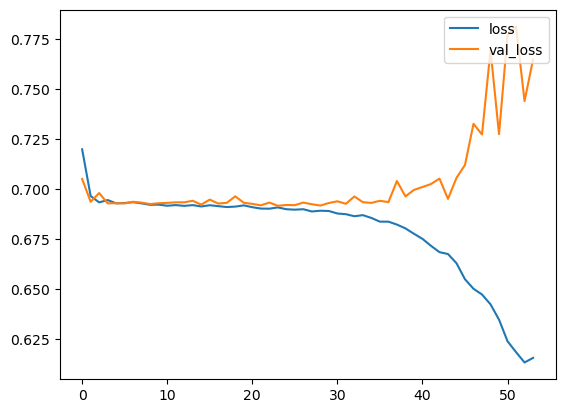

In [26]:
plt.figure()
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend(loc = 'upper right')
plt.show()

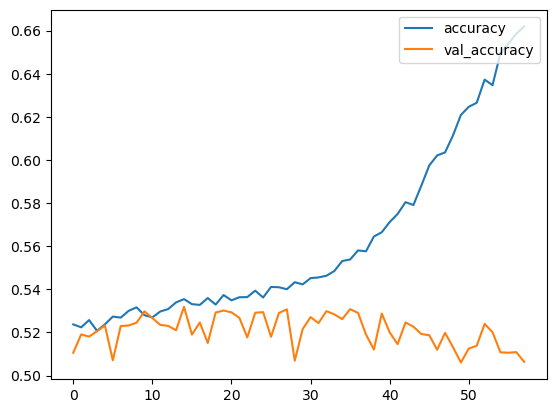

In [11]:
plt.figure()
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.legend(loc = 'upper right')
plt.show()

In [ ]:
os.chdir('/home/manhducnmd/pp_dijet/Model_results')

Loading a sample model for testing

In [55]:
#loaded_model = keras.models.load_model('run_5_id10_500_25.keras')
loaded_model = cwola

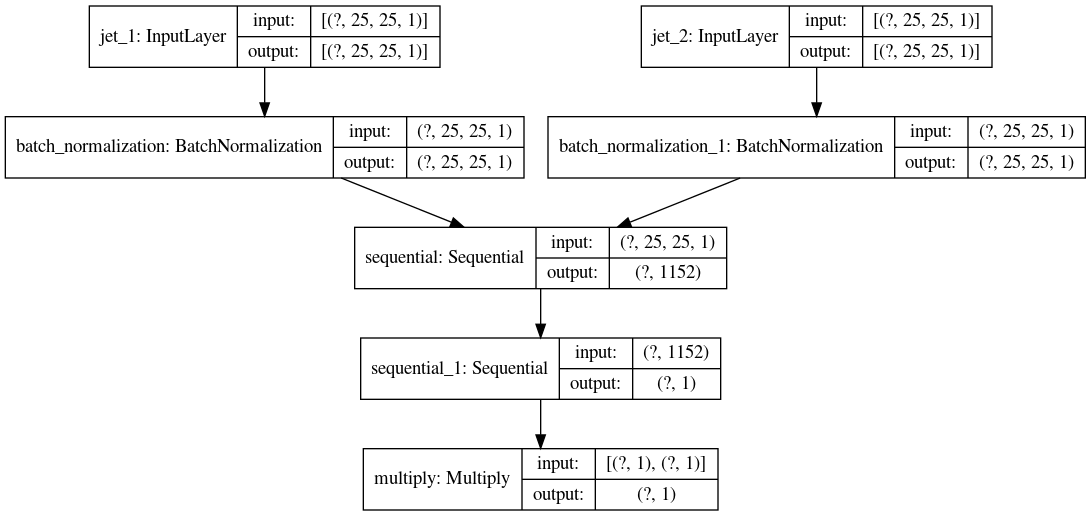

In [8]:
keras.utils.plot_model(loaded_model, "multi_input_and_output_model.png", show_shapes=True)

In [14]:
print(loaded_model.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
jet_1 (InputLayer)              [(None, 25, 25, 1)]  0                                            
__________________________________________________________________________________________________
jet_2 (InputLayer)              [(None, 25, 25, 1)]  0                                            
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 25, 25, 1)    4           jet_1[0][0]                      
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 25, 25, 1)    4           jet_2[0][0]                      
____________________________________________________________________________________________

In [22]:
os.chdir(r'/home/manhducnmd/pp_dijet/Results_full')

In [23]:
bkg_sr_jet_1 = np.load('test_full_background_images_sr_25_jet_1.npy')
bkg_sr_jet_2 = np.load('test_full_background_images_sr_25_jet_2.npy')
signal_sr_jet_1 = np.load('id10_sr_25_jet_1.npy')
signal_sr_jet_2 = np.load('id10_sr_25_jet_2.npy')



In [24]:
signal_test_1 = signal_sr_jet_1[-20000:]
signal_test_2 = signal_sr_jet_2[-20000:]

bkg_test_1 = bkg_sr_jet_1[-20000:]
bkg_test_2 = bkg_sr_jet_2[-20000:]


test_label_signal = np.ones(np.shape(signal_test_1)[0])
test_label_bkg = np.zeros(np.shape(bkg_test_1)[0])

x_test_1 = np.concatenate((signal_test_1, bkg_test_1))
x_test_2 = np.concatenate((signal_test_2, bkg_test_2))
y_test = np.concatenate((test_label_signal, test_label_bkg))

#x_test = np.stack([x_test_1, x_test_2], axis = -1)
x_test_1 = x_test_1.reshape((np.shape(x_test_1)[0],25,25,1))
x_test_2 = x_test_2.reshape((np.shape(x_test_2)[0],25,25,1))


In [56]:
x_predict = loaded_model.predict([x_test_1, x_test_2])

In [57]:
x_predict_0 = x_predict[y_test == 0]
x_predict_1 = x_predict[y_test == 1]


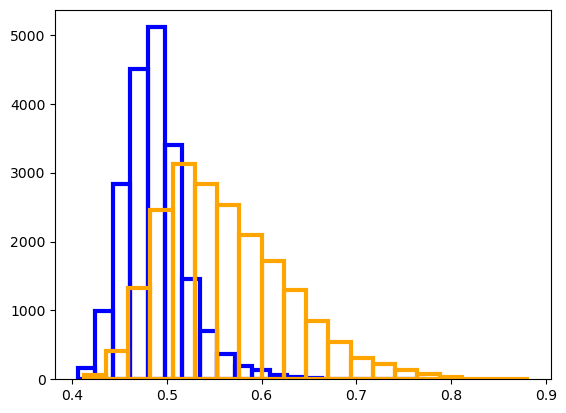

In [58]:
plt.hist(x_predict_0, bins = 20, color='blue', edgecolor='blue', fc="None", lw=3)
plt.hist(x_predict_1, bins = 20, color='orange', edgecolor='orange', fc="None", lw=3)
plt.show()

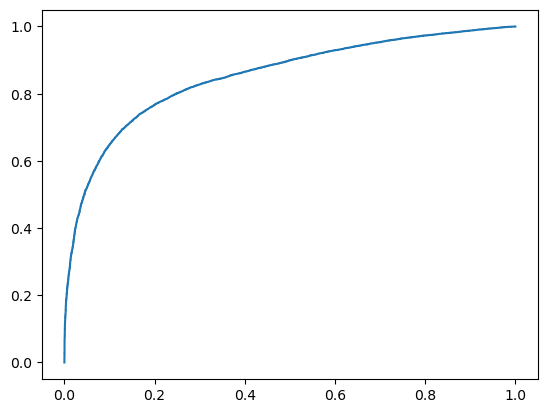

0.8520987175


In [59]:
fpr, tpr, th = roc_curve(y_test, x_predict)
plt.plot(fpr, tpr)
plt.show()
f = interpolate.interp1d(fpr, tpr)
epsilon_s = f([0.001, 0.01, 0.1])
print(roc_auc_score(y_test, x_predict))

In [60]:
print(epsilon_s)

[0.1013  0.26495 0.6482 ]


In [61]:
n_train_sr_signal = 1200

In [62]:
print(np.sqrt(2*((n_train_sr_signal*epsilon_s[0]+25000*0.001)*np.log(n_train_sr_signal*epsilon_s[0]/(25000*0.001) + 1) - 
                 n_train_sr_signal*epsilon_s[0])))

16.591565217724618
